In [1]:
# env info
#!conda info && nvcc -V && python -c "import torch, torchvision; print('PyTorch Version:', torch.__version__); print('Torchvision Version:', torchvision.__version__)"

In [2]:
import os
import torch
from torch import nn
from torch.nn import init
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchinfo import summary
from adder.adder import Adder2D, Adder2DFunction
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import scipy.stats as stats
import math
import warnings
import collections
import LARC
import LAMB

warnings.filterwarnings("ignore")
if torch.backends.cudnn.is_available():  # speed up cnn
    torch.backends.cudnn.enabled = True
#os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
#os.environ["CUDA_DEVICES_ORDER"]="PCI_BUS_ID"
#os.environ["CUDA_VISIBLE_DEVICES"] = "1"
torch.cuda.set_device(1)
print(torch.cuda.current_device())

Using /root/.cache/torch_extensions/py38_cu114 as PyTorch extensions root...
Detected CUDA files, patching ldflags
Emitting ninja build file /root/.cache/torch_extensions/py38_cu114/adder_cuda/build.ninja...
Building extension module adder_cuda...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)
ninja: no work to do.
Loading extension module adder_cuda...
1


In [3]:
args = {}
kwargs = {}
args['clean'] = False
args['batch_size'] = 1000
args['epochs'] = 63  # 7, 15, 31, 63, 127, 255 for CosineAnnealingWarmRestarts
args['lr'] = 0.1  # Learning rate is how fast it will decend.
args['optimizer'] = 'SGD'  # 'SGD', 'SGD_nesterov', 'AdamW', 'AdamW_amsgrad', 'Adadelta', 'RMSprop', 'LAMB'
# 'Const', 'Step', 'Cos', 'CosAn', 'OneCycle'
args['scheduler'] = 'Const'
args['log_interval'] = 10
args['cuda'] = True
args['seed'] = 42  # random seed
args['timer'] = True
args['cam'] = False
args['verb'] = True
args['save'] = [1, args['epochs']//3, args['epochs']*2//3, args['epochs']] if args['epochs'] > 8 \
                else [1, args['epochs']//2, args['epochs']] # save model at 1, 1/3 epochs, 2/3 epochs, final epochs
args['bins'] = 200

print(args)

torch.manual_seed(args['seed'])

{'clean': False, 'batch_size': 1000, 'epochs': 63, 'lr': 0.1, 'optimizer': 'SGD', 'scheduler': 'Const', 'log_interval': 10, 'cuda': True, 'seed': 42, 'timer': True, 'cam': False, 'verb': True, 'save': [1, 21, 42, 63], 'bins': 200}


In [4]:
if args['clean']:
    import shutil
    #dir_list = ["./checkpoints", "./images"]
    dir_list = ["./checkpoints"]
    for d in dir_list:
        if os.path.exists(d):
            shutil.rmtree(d)
        if not os.path.exists(d):
            os.makedirs(d)

In [5]:
if args['cam']:
    import cv2
    from pytorch_grad_cam import GradCAM
    from pytorch_grad_cam import GuidedBackpropReLUModel
    from pytorch_grad_cam.utils.image import show_cam_on_image, deprocess_image, preprocess_image
    from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

In [6]:
# define macro
LOSS_SCALE = 1000  # amplify average loss for significant ploting
INIT_LR = 0.001  # initial learning rate
#BOUND = 4
TC = 0.02 # 
VV = 10

NUM_CLASSES = 10 # cifiar 10
BIAS = False

# define global var
df_dict = {}

In [7]:
class LayerNorm(nn.Module):
    def __init__(self, batch_size=1, eps: float = 1e-5, affine: bool = True):
        
        super().__init__()
        
        self.batch_size = batch_size
        self.eps = eps
        self.affine = affine
        self.test = test
        
        if self.affine:
            self.scale = nn.Parameter(torch.ones(self.batch_size))
            self.shift = nn.Parameter(torch.zeros(self.batch_size))
        
    def forward(self, x: torch.Tensor):
        N, C, *kernel_shape = x.shape
        #assert N == self.batch_size
        x = x.view(N, -1)
        var, mean = torch.var_mean(x, dim=1, keepdim=True)
        if self.affine:
            x = self.scale.view(self.batch_size, -1) * (x - mean) / (torch.sqrt(var + self.eps)) + self.shift.view(self.batch_size, -1)
        else:
            x = (x - mean) / (torch.sqrt(var + self.eps))
            
        return x.view(N, C, *kernel_shape)


class conv2d(nn.Conv2d): # with Weight Standardization

    def __init__(self, in_channels, out_channels, kernel_size, stride=1,
                 padding=0, dilation=1, groups=1, bias=False, aws=True, eps=1e-5):
        super(conv2d, self).__init__(in_channels, out_channels, kernel_size, stride, 
                                     padding, dilation, groups, bias)
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.aws = aws
        self.eps = eps
        if self.aws:
            self.scale = nn.Parameter(torch.ones(self.out_channels))
            self.shift = nn.Parameter(torch.zeros(self.out_channels))

    def forward(self, x):
        
        weight = self.weight

        c_out, c_in, *kernel_shape = weight.shape
        assert c_in == self.in_channels
        assert c_out == self.out_channels
        weight = weight.view(c_out, -1)
        var, mean = torch.var_mean(weight, dim=1, keepdim=True)
        
        if self.aws:
            weight = self.scale.view(c_out, -1) * (weight - mean) / (torch.sqrt(var + self.eps)) + self.shift.view(c_out, -1)
        else:
            weight = (weight - mean) / (torch.sqrt(var + self.eps))
            
        weight = weight.view(c_out, c_in, *kernel_shape)
                
        return F.conv2d(x, weight, self.bias, self.stride,
                        self.padding, self.dilation, self.groups)

class adder2d(Adder2D): # with Weight Standardization

    def __init__(self, in_channels, out_channels, kernel_size, stride=1,
                 padding=0, bias=False, aws=True, eps=1e-5):
        super(adder2d, self).__init__(in_channels, out_channels, kernel_size, stride,
                                      padding, bias)
        
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.aws = aws
        self.eps = eps
        if self.aws:
            self.scale = nn.Parameter(torch.ones(self.out_channels))
            self.shift = nn.Parameter(torch.zeros(self.out_channels))

    def forward(self, x):
        
        weight = self.adder

        c_out, c_in, *kernel_shape = weight.shape
        assert c_in == self.in_channels
        assert c_out == self.out_channels
        weight = weight.view(c_out, -1)
        var, mean = torch.var_mean(weight, dim=1, keepdim=True)

        if self.aws:
            weight = self.scale.view(c_out, -1) * (weight - mean) / (torch.sqrt(var + self.eps)) + self.shift.view(c_out, -1)
        else:
            weight = (weight - mean) / (torch.sqrt(var + self.eps))
        
        weight = weight.view(c_out, c_in, *kernel_shape)

        return Adder2DFunction.apply(x, weight, self.kernel_size, self.stride,
                                    self.padding, self.eta, self.quantize, self.weight_bits, self.quantize_v)

In [30]:

class BasicBlockCNN(nn.Module):
    expansion=1

    def __init__(self, inplanes, planes, stride=1, downsample=None, en_ln=False, batch_size=1):
        super(BasicBlockCNN, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride
        self.en_ln = en_ln
        if self.en_ln:
            self.ln1 = LayerNorm(batch_size)
            self.ln2 = LayerNorm(batch_size)

    def forward(self, x):
        residual = x
        if self.en_ln:
            x = self.ln1(x)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        if self.en_ln:
            out = self.ln2(out)
        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class ResNetCNN(nn.Module):

    def __init__(self, block, layers, num_classes=10, en_ln=False, batch_size=1):
        super(ResNetCNN, self).__init__()
        self.inplanes = 16
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.en_ln = en_ln
        self.batch_size = batch_size
        self.layer1 = self._make_layer(block, 16, layers[0], en_ln=self.en_ln, batch_size=self.batch_size)
        self.layer2 = self._make_layer(block, 32, layers[1], stride=2, en_ln=self.en_ln, batch_size=self.batch_size)
        self.layer3 = self._make_layer(block, 64, layers[2], stride=2, en_ln=self.en_ln, batch_size=self.batch_size)
        self.avgpool = nn.AvgPool2d(8, stride=1)
        self.fc = nn.Conv2d(64 * block.expansion, num_classes, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(num_classes)

        for m in self.modules():
            if isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
         
    def _make_layer(self, block, planes, blocks, stride=1, en_ln=False, batch_size=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            if en_ln:
                downsample = nn.Sequential(
                    LayerNorm(batch_size),
                    nn.Conv2d(self.inplanes, planes * block.expansion, kernel_size=1, stride=stride, bias=False),
                    nn.BatchNorm2d(planes * block.expansion)
                )
            else:
                downsample = nn.Sequential(
                    nn.Conv2d(self.inplanes, planes * block.expansion, kernel_size=1, stride=stride, bias=False),
                    nn.BatchNorm2d(planes * block.expansion)
                )

        layers = []
        layers.append(block(inplanes = self.inplanes, planes = planes, stride = stride, downsample = downsample, en_ln=en_ln, batch_size=batch_size))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(inplanes = self.inplanes, planes = planes, en_ln=en_ln, batch_size=batch_size))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = self.fc(x)
        x = self.bn2(x)

        return x.view(x.size(0), -1)


def resnet20cnn(**kwargs):
    return ResNetCNN(BasicBlockCNN, [3, 3, 3], **kwargs)
   


In [8]:



def conv3x3(in_planes, out_planes, stride=1):
    " 3x3 convolution with padding "
    return Adder2D(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion=1

    def __init__(self, inplanes, planes, stride=1, downsample=None, en_ln=False, batch_size=1):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride = stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride
        self.en_ln = en_ln
        if self.en_ln:
            self.ln1 = LayerNorm(batch_size)
            self.ln2 = LayerNorm(batch_size)

    def forward(self, x):
        residual = x
        if self.en_ln:
            x = self.ln1(x)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        if self.en_ln:
            out = self.ln2(out)
        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=10, en_ln=False, batch_size=1):
        super(ResNet, self).__init__()
        self.inplanes = 16
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.en_ln = en_ln
        self.batch_size = batch_size
        self.layer1 = self._make_layer(block, 16, layers[0], en_ln=self.en_ln, batch_size=self.batch_size)
        self.layer2 = self._make_layer(block, 32, layers[1], stride=2, en_ln=self.en_ln, batch_size=self.batch_size)
        self.layer3 = self._make_layer(block, 64, layers[2], stride=2, en_ln=self.en_ln, batch_size=self.batch_size)
        self.avgpool = nn.AvgPool2d(8, stride=1)
        self.fc = nn.Conv2d(64 * block.expansion, num_classes, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(num_classes)

        for m in self.modules():
            if isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
         
    def _make_layer(self, block, planes, blocks, stride=1, en_ln=False, batch_size=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            if en_ln:
                downsample = nn.Sequential(
                    LayerNorm(batch_size),
                    Adder2D(self.inplanes, planes * block.expansion, kernel_size=1, stride=stride, bias=False),
                    nn.BatchNorm2d(planes * block.expansion)
                )
            else:
                downsample = nn.Sequential(
                    Adder2D(self.inplanes, planes * block.expansion, kernel_size=1, stride=stride, bias=False),
                    nn.BatchNorm2d(planes * block.expansion)
                )

        layers = []
        layers.append(block(inplanes = self.inplanes, planes = planes, stride = stride, downsample = downsample, en_ln=en_ln, batch_size=batch_size))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(inplanes = self.inplanes, planes = planes, en_ln=en_ln, batch_size=batch_size))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = self.fc(x)
        x = self.bn2(x)

        return x.view(x.size(0), -1)


def resnet20(**kwargs):
    return ResNet(BasicBlock, [3, 3, 3], **kwargs)
   


In [9]:


class adder2daws(Adder2D): # with Weight Standardization

    def __init__(self, in_channels, out_channels, kernel_size, stride=1,
                 padding=0, bias=False, aws=True, eps=1e-5):
        super(adder2daws, self).__init__(in_channels, out_channels, kernel_size, stride,
                                         padding, bias)
        
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.aws = aws
        self.eps = eps
        if self.aws:
            self.scale = nn.Parameter(torch.ones(self.out_channels))
            self.shift = nn.Parameter(torch.zeros(self.out_channels))

    def forward(self, x):
        
        weight = self.adder

        c_out, c_in, *kernel_shape = weight.shape
        assert c_in == self.in_channels
        assert c_out == self.out_channels
        weight = weight.view(c_out, -1)
        var, mean = torch.var_mean(weight, dim=1, keepdim=True)

        if self.aws:
            weight = self.scale.view(c_out, -1) * (weight - mean) / (torch.sqrt(var + self.eps)) + self.shift.view(c_out, -1)
        else:
            weight = (weight - mean) / (torch.sqrt(var + self.eps))
        
        weight = weight.view(c_out, c_in, *kernel_shape)

        return Adder2DFunction.apply(x, weight, self.kernel_size, self.stride,
                                    self.padding, self.eta, self.quantize, self.weight_bits, self.quantize_v)



def conv3x3aws(in_planes, out_planes, stride=1): #adaptive weight standarization
    " 3x3 convolution with padding "
    return adder2daws(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)


class BasicBlockAWS(nn.Module):
    expansion=1

    def __init__(self, inplanes, planes, stride=1, downsample=None, en_ln=False, batch_size=1):
        super(BasicBlockAWS, self).__init__()
        self.conv1 = conv3x3aws(inplanes, planes, stride = stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3aws(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride
        self.en_ln = en_ln
        if self.en_ln:
            self.ln1 = LayerNorm(batch_size)
            self.ln2 = LayerNorm(batch_size)

    def forward(self, x):
        residual = x
        if self.en_ln:
            x = self.ln1(x)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        if self.en_ln:
            out = self.ln2(out)
        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class ResNetAWS(nn.Module):

    def __init__(self, block, layers, num_classes=10, en_ln=False, batch_size=1):
        super(ResNetAWS, self).__init__()
        self.inplanes = 16
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.en_ln = en_ln
        self.batch_size = batch_size
        self.layer1 = self._make_layer(block, 16, layers[0], en_ln=self.en_ln, batch_size=self.batch_size)
        self.layer2 = self._make_layer(block, 32, layers[1], stride=2, en_ln=self.en_ln, batch_size=self.batch_size)
        self.layer3 = self._make_layer(block, 64, layers[2], stride=2, en_ln=self.en_ln, batch_size=self.batch_size)
        self.avgpool = nn.AvgPool2d(8, stride=1)
        self.fc = nn.Conv2d(64 * block.expansion, num_classes, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(num_classes)

        for m in self.modules():
            if isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
         
    def _make_layer(self, block, planes, blocks, stride=1, en_ln=False, batch_size=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            if en_ln:
                downsample = nn.Sequential(
                    LayerNorm(batch_size),
                    adder2daws(self.inplanes, planes * block.expansion, kernel_size=1, stride=stride, bias=False),
                    nn.BatchNorm2d(planes * block.expansion)
                )
            else:
                downsample = nn.Sequential(
                    adder2daws(self.inplanes, planes * block.expansion, kernel_size=1, stride=stride, bias=False),
                    nn.BatchNorm2d(planes * block.expansion)
                )

        layers = []
        layers.append(block(inplanes = self.inplanes, planes = planes, stride = stride, downsample = downsample, en_ln=en_ln, batch_size=batch_size))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(inplanes = self.inplanes, planes = planes, en_ln=en_ln, batch_size=batch_size))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = self.fc(x)
        x = self.bn2(x)

        return x.view(x.size(0), -1)


def resnet20aws(**kwargs):
    return ResNetAWS(BasicBlockAWS, [3, 3, 3], **kwargs)
   


In [10]:
# data loader
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

data_train = datasets.CIFAR10('./data', transform=transform_train, download=False)
data_test = datasets.CIFAR10('./data', train=False, transform=transform_test)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=args['batch_size'], shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(data_test, batch_size=args['batch_size'], num_workers=0)

In [11]:
def init_laplace(tensor):
    if 0 in tensor.shape:
        warnings.warn("Initializing zero-element tensors is a no-op")
        return tensor
    fan = init._calculate_correct_fan(tensor, 'fan_in')
    gain = VV * init.calculate_gain('relu', 0)
    std = gain / math.sqrt(2 * fan)
    #print(f'fan:{fan:.2f}\tgain:{gain:.2f}\tstd:{std:.2f}')
    gen = torch.distributions.laplace.Laplace(torch.tensor([0.0]), torch.tensor([std]))
    #gen = torch.distributions.laplace.Laplace(torch.tensor([0.0]), torch.tensor([1/math.sqrt(2)]))
    return nn.Parameter(gen.rsample(tensor.size()).squeeze(-1))


def init_uniform(tensor):
    if 0 in tensor.shape:
        warnings.warn("Initializing zero-element tensors is a no-op")
        return tensor
    fan = init._calculate_correct_fan(tensor, 'fan_in')
    gain = VV * init.calculate_gain('relu', 0)
    std = gain / math.sqrt(fan)
    bound = math.sqrt(5.0) * std
    #print(f'fan:{fan:.2f}\tgain:{gain:.2f}\tstd:{std:.2f}\tbound:{bound:2f}')
    return tensor.uniform_(-bound, bound)

def init_norm(tensor):
    if 0 in tensor.shape:
        warnings.warn("Initializing zero-element tensors is a no-op")
        return tensor
    fan = init._calculate_correct_fan(tensor, 'fan_in')
    gain = VV * init.calculate_gain('relu', 0)
    std = gain / math.sqrt(fan)
    return tensor.normal_(0, std)


def initParams(model, init_mode='None'):
    global is_adder
    
    assert init_mode in ['None', 'uniform', 'norm', 'laplace'], f"init_mode is {init_mode}"
        
    with torch.no_grad():
        for i, m in enumerate(model.modules()):
            if isinstance(m, nn.Conv2d):
                is_adder.append(False)
                # default init:
                # init.kaiming_uniform_(self.weight, a=math.sqrt(5))
                if init_mode is 'norm':
                    init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
                else:
                    init.kaiming_uniform_(m.weight, a=0)
            elif isinstance(m, nn.BatchNorm2d):
                # default init:
                init.constant_(m.weight, 1)
                init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                # use default init:
                init.kaiming_uniform_(self.weight, a=0)
            elif isinstance(m, Adder2D):
                is_adder.append(True)
                if init_mode is 'laplace':
                    m.adder = init_laplace(m.adder)
                elif init_mode is 'uniform':
                    #m.adder.uniform_(-BOUND, BOUND)
                    init_uniform(m.adder)
                elif init_mode is 'norm':
                    #m.adder = nn.Parameter(init.normal_(m.adder))
                    init_norm(m.adder)
                else:
                    #init.kaiming_uniform_(m.adder, a=0)
                    m.adder = nn.Parameter(init.normal_(m.adder))
                    
    checkpoint = {'model': model.state_dict()}
    torch.save(checkpoint, './checkpoints/' + str(type(model).__name__) + '_0' + '.pth')
    
get_stat_flag = 0
def get_stat(model, aws=False):
    global get_stat_flag
    w_norm = []
    g_norm = []
    w_std = []
    g_std = []
    scale = []
    shift = []
    #for i, p in enumerate(optim.param_groups[0]['params']):
    #    if i in [0, 3, 6, 9, 12]: # conv1 : conv5
    #        w_norm.append(torch.norm(p.data).cpu())
    #        g_norm.append(torch.norm(p.grad.data).cpu())
    #        w_std.append(torch.std(p.data).cpu())
    #        g_std.append(torch.std(p.grad.data).cpu())

    i = 0
    for n, p in model.named_parameters():
        if 'conv' in n and 'layer' in n and p.dim() == 4:
            if get_stat_flag == 0:
                print('----- layer {} \t {} \t param size {} -----'.format(i, n, p.size()))
            w_norm.append(torch.norm(p.data).cpu())
            g_norm.append(torch.norm(p.grad.data).cpu())
            w_std.append(torch.std(p.data).cpu())
            g_std.append(torch.std(p.grad.data).cpu()) 
            i += 1
        if 'scale' in n and 'conv' in n and aws:
            scale.append(torch.mean(p.data).cpu())
        if 'shift' in n and 'conv' in n and aws:
            shift.append(torch.mean(p.data).cpu())
    get_stat_flag = 1
    if aws:
        return w_norm, g_norm, w_std, g_std, scale, shift
    else:
        return w_norm, g_norm, w_std, g_std
    
def select_optimizer_scheduler(opt='SGD', sch='Const', aws=False):
    global optimizer, scheduler
    
    lr = INIT_LR if sch is 'OneCycleLR' else args['lr']
        
    # number of iteration in each epoch
    iter_epoch = len(train_loader.dataset) // args['batch_size']


    if aws:
        tiny_params = []
        normal_params = []
        for key, value in dict(model.named_parameters()).items():
            if value.requires_grad:
                if 'conv' in key and ('scale' in key or 'shift' in key):
                    tiny_params.append(value)
                    print('tiny params', key)
                else:
                    normal_params.append(value)
                    print('normal params', key)
        params = [{'params': normal_params, 'lr': lr, 'weight_decay': 5e-4},
                  {'params': tiny_params, 'lr': 0.01 * lr, 'weight_decay': 5e-4}]
    else:
        params = model.parameters()
    
    if opt is 'SGD':
        optimizer = optim.SGD(params, lr=lr, momentum=0.5, weight_decay=5e-5, nesterov=False)
    elif opt is 'SGD_nesterov':
        optimizer = optim.SGD(params, lr=lr, momentum=0.5, weight_decay=5e-5, nesterov=True)
    elif opt is 'AdamW':
        optimizer = optim.AdamW(params, lr=lr, betas=(0.9, 0.999), eps=1e-8, weight_decay=5e-4, amsgrad=False)
    elif opt is 'AdamW_amsgrad':
        optimizer = optim.AdamW(params, lr=lr, betas=(0.9, 0.999), eps=1e-8, weight_decay=5e-4, amsgrad=True)
    elif opt is 'Adadelta':
        optimizer = optim.Adadelta(params, lr=lr)
    elif opt is 'RMSprop':
        optimizer = optim.RMSprop(params, lr=lr, alpha=0.99, momentum=0.5, centered=True)
    elif opt is 'LAMB':
        optimizer = LAMB.Lamb(model.params, lr=lr, weight_decay=5e-4, betas=(.9, .999), adam=False)
    else:
        raise ValueError(f'Wrong Opt: {opt}.')  

        
                  
    if sch is 'Const':
        scheduler = None
    elif sch is 'Step':
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=iter_epoch*args['epochs']//3, gamma=0.2)  # every 1/3 epoch lr*0.1
    elif sch is 'Cos':
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=iter_epoch*args['epochs'], eta_min=0.001)  # half cos
    elif sch is 'CosAn':
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=iter_epoch*args['epochs']//5, eta_min=0.001),  # 5 half cos
    elif sch is 'CosAnWR':
        scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=iter_epoch*1, T_mult=2, eta_min=0.001),  # 5 half cos, epoch=7, 15, 31, 63, 127, 255
    elif sch is 'OneCycle':
        scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=args['lr'], steps_per_epoch=iter_epoch, anneal_strategy='cos', epochs=args['epochs']) # strategy: cos, linear 
    else:
        raise ValueError(f'Wrong Sch: {sch}.')  


def train(epoch, sch, timer, aws=False):
    global count, train_loss_list, iteration_list, lr_list
    global wnorm1_list, wnorm2_list, wnorm3_list, wnorm4_list, wnorm5_list, gnorm1_list, gnorm2_list, gnorm3_list, gnorm4_list, gnorm5_list
    global wstd1_list, wstd2_list, wstd3_list, wstd4_list, wstd5_list, gstd1_list, gstd2_list, gstd3_list, gstd4_list, gstd5_list
    if aws:
        global scale1_list, scale2_list, scale3_list, scale4_list, scale5_list, shift1_list, shift2_list, shift3_list, shift4_list, shift5_list
    global optimizer, criterion, scheduler
    train_loss = 0

    model.train()

    if timer:
        global time
        time = 0
        start = torch.cuda.Event(enable_timing=True)
        end = torch.cuda.Event(enable_timing=True)

    for batch_idx, (data, target) in enumerate(train_loader):
        if args['cuda']:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()

        if timer:
            start.record()
        outputs = model(data)
        if timer:
            end.record()
            torch.cuda.synchronize()
            elapsed = start.elapsed_time(end)
            time += elapsed
    
        loss = criterion(outputs, target)
        train_loss += loss.item() / float(len(data))
        loss.backward()
        optimizer.step()
        
        count += 1
        if count % args['log_interval'] == 0 or count == 1:
            accuracy = test()
            model.train()
            if count == 1:
                train_loss = train_loss * LOSS_SCALE
            else:
                train_loss = train_loss / float(args['log_interval']) * LOSS_SCALE
            train_loss_list.append(train_loss)
            iteration_list.append(count)
            lr = optimizer.param_groups[0]["lr"]
            lr_list.append(lr)
            
            if aws:
                w_norm, g_norm, w_std, g_std, scale, shift = get_stat(model, aws)
            else:  
                w_norm, g_norm, w_std, g_std = get_stat(model, aws)   
                
            wnorm1_list.append(w_norm[0])
            wnorm2_list.append(w_norm[4])
            wnorm3_list.append(w_norm[10])
            wnorm4_list.append(w_norm[14])
            wnorm5_list.append(w_norm[17])
            gnorm1_list.append(g_norm[0])
            gnorm2_list.append(g_norm[4])
            gnorm3_list.append(g_norm[10])
            gnorm4_list.append(g_norm[14])
            gnorm5_list.append(g_norm[17])
            wstd1_list.append(w_std[0])
            wstd2_list.append(w_std[4])
            wstd3_list.append(w_std[10])
            wstd4_list.append(w_std[14])
            wstd5_list.append(w_std[17])
            gstd1_list.append(g_std[0])
            gstd2_list.append(g_std[4])
            gstd3_list.append(g_std[10])
            gstd4_list.append(g_std[14])
            gstd5_list.append(g_std[17])
            
            if aws:
                scale1_list.append(scale[0])
                scale2_list.append(scale[1])
                scale3_list.append(scale[2])
                scale4_list.append(scale[3])
                scale5_list.append(scale[4])
                shift1_list.append(shift[0])
                shift2_list.append(shift[1])
                shift3_list.append(shift[2])
                shift4_list.append(shift[3])
                shift5_list.append(shift[4])

            if timer:
                if args['verb']:
                    print('Train Epoch:{} [{}/{}]\tIter:{}  \tElapsed:{:.2f}s\tLR:{:.4f}\tLoss:{:.4f}\tAccuracy:{:.2f}\tW1:{:.4f}\tW5:{:.4f}\tG1:{:.4f}\tG5:{:.4f}'.format(
                          epoch, (batch_idx+1)*len(data), len(train_loader.dataset), count,
                          time/1000, lr, train_loss, accuracy, w_norm[0], w_norm[4], g_norm[0], g_norm[4]))
                time = 0
            else:
                if args['verb']:
                    print('Train Epoch:{} [{}/{}]\tIter:{}  \tLR:{:.4f}\tLoss:{:.4f}\tAccuracy:{:.2f}\tW1:{:.4f}\tW2:{:.4f}\tG1{:.4f}\tG2{:.4f}'.format(
                          epoch, (batch_idx+1)*len(data), len(train_loader.dataset), count,
                          lr, train_loss, accuracy, w_norm[0], w_norm[4], g_norm[0], g_norm[4]))

            train_loss = train_loss / LOSS_SCALE if count is 1 else 0

        if sch is not 'Const':
            scheduler.step()
        

def test():
    global test_loss_list, accuracy_list
    global criterion
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            if args['cuda']:
                data, target = data.cuda(), target.cuda()
            data, target = Variable(data, volatile=True), Variable(target)
            outputs = model(data)
            # sum up iter or epoch loss
            test_loss += criterion(outputs, target).item()
            # pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
            pred = torch.max(outputs.data, 1)[1]
            correct += pred.eq(target.data.view_as(pred)).long().cpu().sum()
    test_loss = test_loss / float(len(test_loader.dataset)) * LOSS_SCALE
    accuracy = 100 * correct.item() / float(len(test_loader.dataset))

    test_loss_list.append(test_loss)
    accuracy_list.append(accuracy)

    return accuracy


def run(model, opt='SGD', sch='Const', init_mode=None, en_larc=False, aws=False):
    '''
    model: LeNet5_BN_FCN(), LeNet5_BN_FAN()
    optim: 'SGD', 'SGD_nesterov', 'AdamW', 'AdamW_amsgrad', 'Adadelta'
    sch: 'Const', 'Step', 'Cos', 'CosAn', 'CosAnWR', 'OneCycle'
    '''
    
    if args['verb']: 
        print(f"{opt}\t{sch}") 
    
    global time, count, df_dict, is_adder
    global train_loss_list, test_loss_list, accuracy_list, iteration_list, lr_list
    global wnorm1_list, wnorm2_list, wnorm3_list, wnorm4_list, wnorm5_list, gnorm1_list, gnorm2_list, gnorm3_list, gnorm4_list, gnorm5_list
    global wstd1_list, wstd2_list, wstd3_list, wstd4_list, wstd5_list, gstd1_list, gstd2_list, gstd3_list, gstd4_list, gstd5_list
    if aws:
        global scale1_list, scale2_list, scale3_list, scale4_list, scale5_list, shift1_list, shift2_list, shift3_list, shift4_list, shift5_list
    global optimizer, criterion, scheduler

    is_adder = []
    # model parameters initialization
    initParams(model, init_mode)
    
    select_optimizer_scheduler(opt, sch, aws)
    if en_larc:
        optimizer = LARC.LARC(optimizer=optimizer, trust_coefficient=TC) # trust_coefficient hyperparam
    criterion = nn.CrossEntropyLoss()

    if args['cuda']:
        model.cuda()
        criterion.cuda()

    time = 0
    count = 0
    train_loss_list = []
    test_loss_list = []
    accuracy_list = []
    iteration_list = []
    lr_list = []
    wnorm1_list = []
    wnorm2_list = []
    wnorm3_list = []
    wnorm4_list = []
    wnorm5_list = []
    gnorm1_list = []
    gnorm2_list = []
    gnorm3_list = []
    gnorm4_list = []
    gnorm5_list = []
    wstd1_list = []
    wstd2_list = []
    wstd3_list = []
    wstd4_list = []
    wstd5_list = []
    gstd1_list = []
    gstd2_list = []
    gstd3_list = []
    gstd4_list = []
    gstd5_list = []
    
    if aws:
        scale1_list = []
        scale2_list = []
        scale3_list = []
        scale4_list = []
        scale5_list = []
        shift1_list = []
        shift2_list = []
        shift3_list = []
        shift4_list = []
        shift5_list = []
    
    
    #for name, param in model.named_parameters():
    #    print(name, param.requires_grad, param.data.size())
    
    #aws_flag = 0
    
    for epoch in range(1, args['epochs']+1):
        train(epoch, sch, args['timer'], aws)
        if epoch in args['save']:
            checkpoint = {
                'model': model.state_dict(),
                #'optimizer': optimizer.state_dict(),
            }
            path = './checkpoints/' + str(type(model).__name__) + '_' + str(epoch) + '.pth'
            os.remove(path) if os.path.exists(path) else None
            torch.save(checkpoint, path)
        #if aws and aws_flag == 0:
        #    if optimizer.param_groups[0]['lr'] < 0.01:
        #        for name, param in model.named_parameters():
        #            if ('scale' in name or 'shift' in name) and 'conv' in name: 
        #                param.requires_grad =True
        #                print('{}.reguires_grad = True'.format(name))
        #        aws_flag = 1
                

    if aws:
        list_all = [iteration_list, train_loss_list,
                    test_loss_list, accuracy_list, lr_list, 
                    wnorm1_list, wnorm2_list, wnorm3_list, wnorm4_list, wnorm5_list, gnorm1_list, gnorm2_list, gnorm3_list, gnorm4_list, gnorm5_list,
                    wstd1_list, wstd2_list, wstd3_list, wstd4_list, wstd5_list, gstd1_list, gstd2_list, gstd3_list, gstd4_list, gstd5_list,
                    scale1_list, scale2_list, scale3_list, scale4_list, scale5_list, shift1_list, shift2_list, shift3_list, shift4_list, shift5_list]
    else:
        list_all = [iteration_list, train_loss_list,
                    test_loss_list, accuracy_list, lr_list, 
                    wnorm1_list, wnorm2_list, wnorm3_list, wnorm4_list, wnorm5_list, gnorm1_list, gnorm2_list, gnorm3_list, gnorm4_list, gnorm5_list,
                    wstd1_list, wstd2_list, wstd3_list, wstd4_list, wstd5_list, gstd1_list, gstd2_list, gstd3_list, gstd4_list, gstd5_list]
        
    df = pd.DataFrame(list_all).transpose()
    
    if aws:
        df.columns = ['iter', 'train_loss', 'test_loss', 'accuracy', 'lr', 
                      'wnorm1', 'wnorm2', 'wnorm3', 'wnorm4', 'wnorm5', 'gnorm1', 'gnorm2', 'gnorm3', 'gnorm4', 'gnorm5',
                      'wstd1', 'wstd2', 'wstd3', 'wstd4', 'wstd5', 'gstd1', 'gstd2', 'gstd3', 'gstd4', 'gstd5',
                      'scale1', 'scale2', 'scale3', 'scale4', 'scale5', 'shift1', 'shift2', 'shift3', 'shift4', 'shift5']
    else:
        df.columns = ['iter', 'train_loss', 'test_loss', 'accuracy', 'lr', 
                      'wnorm1', 'wnorm2', 'wnorm3', 'wnorm4', 'wnorm5', 'gnorm1', 'gnorm2', 'gnorm3', 'gnorm4', 'gnorm5',
                      'wstd1', 'wstd2', 'wstd3', 'wstd4', 'wstd5', 'gstd1', 'gstd2', 'gstd3', 'gstd4', 'gstd5']
        
    name = type(model).__name__
    #str_larc = 'enlarc' if en_larc else 'nolarc'
    #path = f'./results/{name}_{opt}_{sch}_{init_mode}_{str_larc}_{epoch}.csv'
    str_aws = 'aws' if aws else 'noaws'
    path = f'./results/{name}_{opt}_{sch}_{init_mode}_{str_aws}_{epoch}.csv'
    df.to_csv(path, index=False)
    df_dict[str(name)] = df

    global get_stat_flag
    get_stat_flag = 0


def plot_train_test(aws=False):
    global train_loss_list, test_loss_list, accuracy_list, iteration_list, lr_list
    global wnorm1_list, wnorm2_list, wnorm3_list, wnorm4_list, wnorm5_list, gnorm1_list, gnorm2_list, gnorm3_list, gnorm4_list, gnorm5_list
    global wstd1_list, wstd2_list, wstd3_list, wstd4_list, wstd5_list, gstd1_list, gstd2_list, gstd3_list, gstd4_list, gstd5_list
    if aws:
        global scale1_list, scale2_list, scale3_list, scale4_list, scale5_list, shift1_list, shift2_list, shift3_list, shift4_list, shift5_list
    
        fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(nrows=4, ncols=2,
                                                                     sharey=False, sharex=False, figsize=(14, 18))
    else:
        fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(nrows=3, ncols=2,
                                                                 sharey=False, sharex=False, figsize=(14, 14))

    # visualization loss
    ax1.plot(iteration_list, train_loss_list, label=f'Train Loss: {train_loss_list[-1]:.4f}')
    ax1.plot(iteration_list, test_loss_list, label=f'Test Loss: {test_loss_list[-1]:.4f}')
    ax1.set_xlabel("Number of iteration")
    ax1.set_ylabel("Loss")
    ax1.set_title("Loss")
    ax1.legend(loc='upper right')

    ax2.plot(iteration_list, accuracy_list, label=f'Accuracy: {max(accuracy_list)}', color='red')
    ax2_ex = ax2.twinx()
    ax2_ex.plot(iteration_list, lr_list, label='Learning Rate', color='blue', alpha=0.3)
    ax2_ex.set_ylabel("Learning Rate")
    ax2.set_xlabel("Number of iteration")
    ax2.set_ylabel("Accuracy")
    ax2.set_title("Accuracy and Learning Rate")
    ax2.legend(loc='lower right')

    ax3.plot(iteration_list, gnorm1_list, label='Conv1 G')
    ax3.plot(iteration_list, gnorm2_list, label='Conv2 G')
    ax3.plot(iteration_list, gnorm3_list, label='Conv3 G')
    ax3.plot(iteration_list, gnorm4_list, label='Conv4 G')
    ax3.plot(iteration_list, gnorm5_list, label='Conv5 G')
    ax3.set_xlabel("Number of iteration")
    ax3.set_ylabel("Grads Norm")
    ax3.set_title("Gradients Norm of Layers")
    ax3.legend(loc='best')

    ax4.plot(iteration_list, wnorm1_list, label='Conv1 W')
    ax4.plot(iteration_list, wnorm2_list, label='Conv2 W')
    ax4.plot(iteration_list, wnorm3_list, label='Conv3 W')
    ax4.plot(iteration_list, wnorm4_list, label='Conv4 W')
    ax4.plot(iteration_list, wnorm5_list, label='Conv5 W')
    ax4.set_xlabel("Number of iteration")
    ax4.set_ylabel("Weights Norm")
    ax4.set_title("Weights Norm of Layers")
    ax4.legend(loc='best')
    
    ax5.plot(iteration_list, gstd1_list, label='Conv1 G')
    ax5.plot(iteration_list, gstd2_list, label='Conv2 G')
    ax5.plot(iteration_list, gstd3_list, label='Conv3 G')
    ax5.plot(iteration_list, gstd4_list, label='Conv4 G')
    ax5.plot(iteration_list, gstd5_list, label='Conv5 G')
    ax5.set_xlabel("Number of iteration")
    ax5.set_ylabel("Grads STD")
    ax5.set_title("Gradients STD of Layers")
    ax5.legend(loc='best')
    
    ax6.plot(iteration_list, wstd1_list, label='Conv1 W')
    ax6.plot(iteration_list, wstd2_list, label='Conv2 W')
    ax6.plot(iteration_list, wstd3_list, label='Conv3 W')
    ax6.plot(iteration_list, wstd4_list, label='Conv4 W')
    ax6.plot(iteration_list, wstd5_list, label='Conv5 W')
    ax6.set_xlabel("Number of iteration")
    ax6.set_ylabel("Weights STD")
    ax6.set_title("Weights STD of Layers")
    ax6.legend(loc='best')

    if aws:
        ax7.plot(iteration_list, scale1_list, label='scale1')
        ax7.plot(iteration_list, scale2_list, label='scale2')
        ax7.plot(iteration_list, scale3_list, label='scale3')
        ax7.plot(iteration_list, scale4_list, label='scale4')
        ax7.plot(iteration_list, scale5_list, label='scale5')
        ax7.set_xlabel("Number of iteration")
        ax7.set_ylabel("Scale")
        ax7.set_title("AWS Scale of Layers")
        ax7.legend(loc='best')
        
        ax8.plot(iteration_list, shift1_list, label='shift1')
        ax8.plot(iteration_list, shift2_list, label='shift2')
        ax8.plot(iteration_list, shift3_list, label='shift3')
        ax8.plot(iteration_list, shift4_list, label='shift4')
        ax8.plot(iteration_list, shift5_list, label='shift5')
        ax8.set_xlabel("Number of iteration")
        ax8.set_ylabel("Shift")
        ax8.set_title("AWS Shift of Layers")
        ax8.legend(loc='best')
    
    fig.tight_layout()
    plt.show()


def plot_multi(df_dict, opt='SGD', sch='ConstLR'):
    fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3,
                                        sharey=False, sharex=True, figsize=(22, 7))

    for key in df_dict.keys():
        ax1.plot(df_dict[key].iter, df_dict[key].train_loss,
                 label=f'{key}: {df_dict[key].train_loss.iloc[-1]:.4f}')
        ax2.plot(df_dict[key].iter, df_dict[key].test_loss,
                 label=f'{key}: {df_dict[key].test_loss.iloc[-1]:.4f}')
        ax3.plot(df_dict[key].iter, df_dict[key].accuracy,
                 label=f'{key}: {max(df_dict[key].accuracy)}')

    key = list(df_dict.keys())[0]
    ax1lr = ax1.twinx()
    ax1lr.plot(df_dict[key].iter, df_dict[key].lr, label='LR', alpha=0.2)
    ax1.set_xlabel("Number of iteration")
    ax1.set_ylabel("Train Loss")
    ax1.set_title(f"Train Loss with {opt} & {sch}")
    ax1.legend(loc='upper right')

    ax2lr = ax2.twinx()
    ax2lr.plot(df_dict[key].iter, df_dict[key].lr, label='LR', alpha=0.2)
    ax2.set_xlabel("Number of iteration")
    ax2.set_ylabel("Test Loss")
    ax2.set_title(f"Test Loss with {opt} & {sch}")
    ax2.legend(loc='upper right')

    ax3lr = ax3.twinx()
    ax3lr.plot(df_dict[key].iter, df_dict[key].lr, label='LR', alpha=0.2)
    ax3.set_xlabel("Number of iteration")
    ax3.set_ylabel("Accuracy")
    ax3.set_title(f"Accuracy with {opt} & {sch}")
    ax3.legend(loc='lower right')

    fig.tight_layout()
    plt.show()

def plot_hist(model):
    global is_adder
    #print('is adder layer: ', ' '.join(str(i)+'.'+str(x) for i, x in enumerate(is_adder)))
    
    name = str(type(model).__name__)
    checkpoints = [name + '_' + str(x) + '.pth' for x in args['save']]
    checkpoints.insert(0, name + '_0' + '.pth')
    
    col_num = 5 if args['epochs'] > 8 else 4
    fig_size = 4
    figs_size = fig_size * col_num
    
    fig, ax = plt.subplots(1,col_num, figsize=(figs_size,fig_size))
    fig.suptitle('Conv Layers Weight Distribution')
    ax = ax.ravel()
    
    for i, axi in enumerate(ax):
        checkpoint = checkpoints[i]
        checkpoint = torch.load('./checkpoints/' + checkpoint)
        model.load_state_dict(checkpoint['model'])
        
        conv_weight = []
        adder_weight = []
        k = 0
        for j, (name, param) in enumerate(model.named_parameters()):
            if param.dim() == 4:
                if is_adder[k]:
                    #print(f'{k} {name} is adder layer')
                    adder_weight.append(param.cpu().data.numpy().flatten())
                else:
                    #print(f'{k} {name} is conv layer')
                    conv_weight.append(param.cpu().data.numpy().flatten())
                k += 1
                
        epoch = 0 if i == 0 else args['save'][i-1]
        axi_ex = axi.twinx()
        
        if len(adder_weight) != 0:
            adder_weight = np.concatenate(adder_weight)
            adder_norm = np.linalg.norm(adder_weight)
            adder_mean = np.mean(adder_weight)
            adder_std = np.std(adder_weight)
            adder_max = np.max(adder_weight)
            adder_min = np.min(adder_weight)
            axi.hist(adder_weight, bins=args['bins'], alpha=0.5, label='Adder')
            a = np.linspace(adder_mean-4*adder_std, adder_mean+4*adder_std, args['bins'])
            axi_ex.plot(a, stats.laplace.pdf(a, adder_mean, adder_std), alpha=0.3, color='red')
            print(f'Weight \tepoch:{epoch} \tadder norm:{adder_norm:.6f}\tadder std:{adder_std:.6f}\tadder max:{adder_max:.6f}\tadder min:{adder_min:.6f}')
        if len(conv_weight) != 0:
            conv_weight = np.concatenate(conv_weight)
            conv_norm = np.linalg.norm(conv_weight)
            conv_mean = np.mean(conv_weight)
            conv_std = np.std(conv_weight)
            conv_max = np.max(conv_weight)
            conv_min = np.min(conv_weight)
            axi.hist(conv_weight, bins=args['bins'], alpha=0.5, label='Conv')
            c = np.linspace(conv_mean-4*conv_std, conv_mean+4*conv_std, args['bins'])
            axi_ex.plot(c, stats.norm.pdf(c, conv_mean, conv_std), alpha=0.3, color='blue')
            print(f'Weight \tepoch:{epoch} \tconv norm:{conv_norm:.6f} \tconv std:{conv_std:.6f} \tconv max:{conv_max:.6f} \tconv  min:{conv_min:.6f}')
        
        axi.legend(loc='best')
        axi.set_title(f'epoch{epoch}')
    
    plt.tight_layout()
    plt.show()
    

In [31]:
model = resnet20cnn()

#summary(model, (1, 3, 32, 32))

In [32]:
run(model, 'SGD', 'Step', 'uniform')

SGD	Step
Train Epoch:1 [1000/50000]	Iter:1  	Elapsed:0.03s	LR:0.1000	Loss:2.6843	Accuracy:10.00	W1:5.6380	W5:5.6685	G1:1.0948	G5:0.4438
Train Epoch:1 [10000/50000]	Iter:10  	Elapsed:0.24s	LR:0.1000	Loss:2.2925	Accuracy:14.16	W1:5.6434	W5:5.6691	G1:0.3180	G5:0.1543
Train Epoch:1 [20000/50000]	Iter:20  	Elapsed:0.26s	LR:0.1000	Loss:1.9650	Accuracy:17.89	W1:5.6481	W5:5.6699	G1:0.3872	G5:0.1853
Train Epoch:1 [30000/50000]	Iter:30  	Elapsed:0.26s	LR:0.1000	Loss:1.8307	Accuracy:28.29	W1:5.6516	W5:5.6707	G1:0.3199	G5:0.1693
Train Epoch:1 [40000/50000]	Iter:40  	Elapsed:0.26s	LR:0.1000	Loss:1.7595	Accuracy:34.19	W1:5.6546	W5:5.6714	G1:0.3096	G5:0.1777
Train Epoch:1 [50000/50000]	Iter:50  	Elapsed:0.26s	LR:0.1000	Loss:1.7112	Accuracy:39.04	W1:5.6582	W5:5.6723	G1:0.3652	G5:0.1999
Train Epoch:2 [10000/50000]	Iter:60  	Elapsed:0.26s	LR:0.1000	Loss:1.6627	Accuracy:38.40	W1:5.6613	W5:5.6733	G1:0.3653	G5:0.2106
Train Epoch:2 [20000/50000]	Iter:70  	Elapsed:0.26s	LR:0.1000	Loss:1.6334	Accuracy:39.86	W

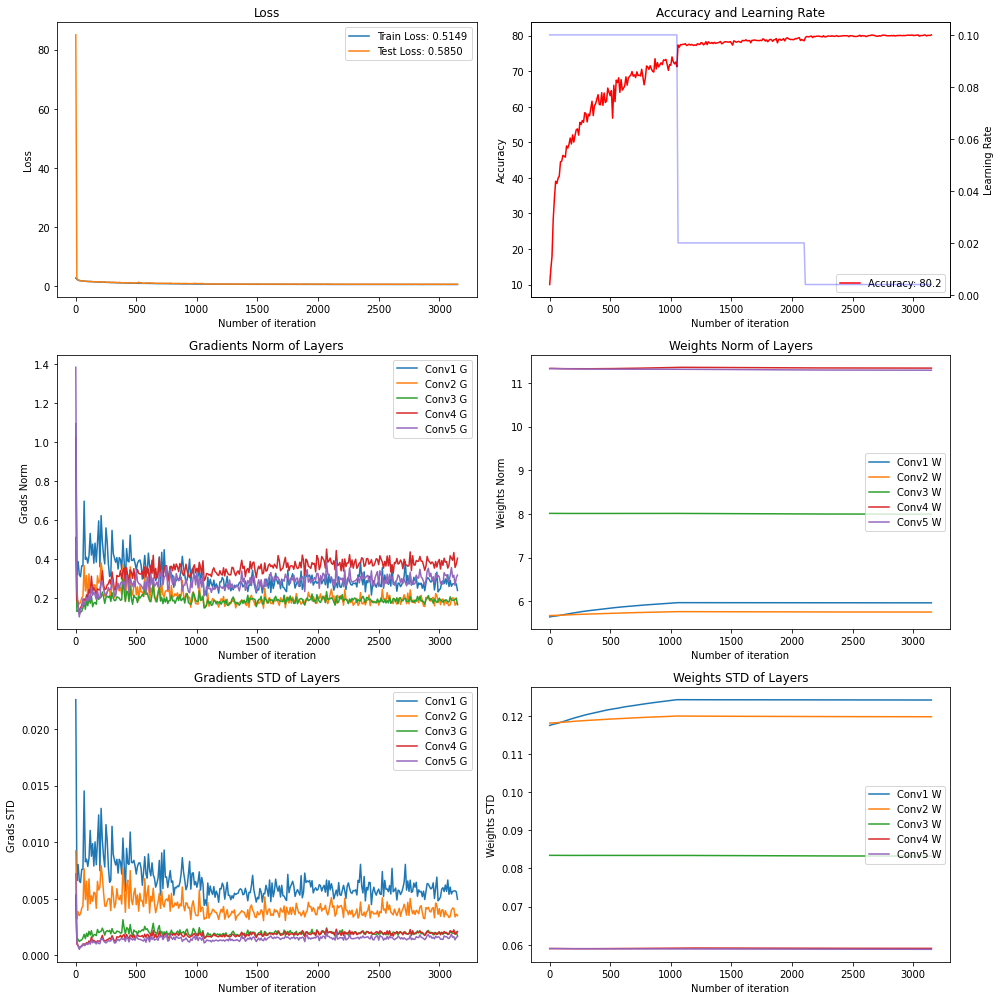

In [33]:
plot_train_test()

Weight 	epoch:0 	conv norm:39.839798 	conv std:0.076545 	conv max:0.608089 	conv  min:-0.605241
Weight 	epoch:1 	conv norm:39.847397 	conv std:0.076559 	conv max:0.607645 	conv  min:-0.605522
Weight 	epoch:21 	conv norm:40.007282 	conv std:0.076864 	conv max:0.640864 	conv  min:-0.626158
Weight 	epoch:42 	conv norm:39.948349 	conv std:0.076751 	conv max:0.644534 	conv  min:-0.629781
Weight 	epoch:63 	conv norm:39.932693 	conv std:0.076721 	conv max:0.644592 	conv  min:-0.629998


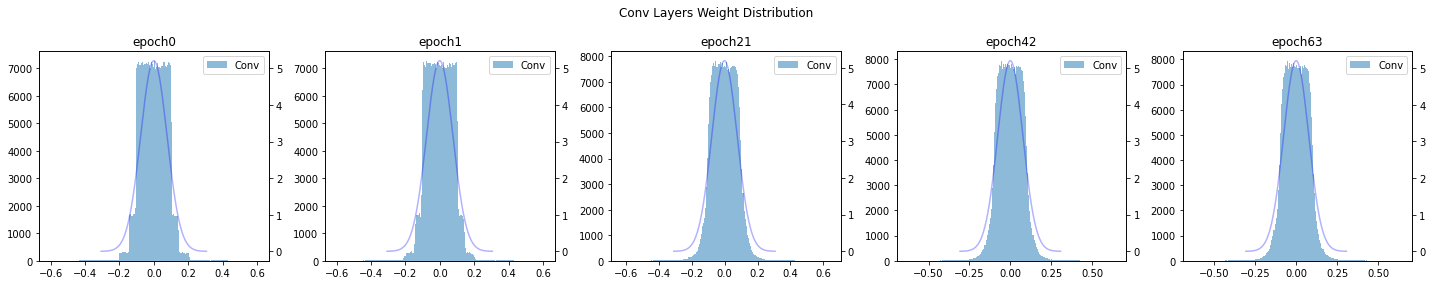

In [34]:
plot_hist(model)

In [35]:
model = resnet20cnn(en_ln=True)

#summary(model, (1, 3, 32, 32))

In [36]:
run(model, 'SGD', 'Step', 'uniform')

SGD	Step
----- layer 0 	 layer1.0.conv1.weight 	 param size torch.Size([16, 16, 3, 3]) -----
----- layer 1 	 layer1.0.conv2.weight 	 param size torch.Size([16, 16, 3, 3]) -----
----- layer 2 	 layer1.1.conv1.weight 	 param size torch.Size([16, 16, 3, 3]) -----
----- layer 3 	 layer1.1.conv2.weight 	 param size torch.Size([16, 16, 3, 3]) -----
----- layer 4 	 layer1.2.conv1.weight 	 param size torch.Size([16, 16, 3, 3]) -----
----- layer 5 	 layer1.2.conv2.weight 	 param size torch.Size([16, 16, 3, 3]) -----
----- layer 6 	 layer2.0.conv1.weight 	 param size torch.Size([32, 16, 3, 3]) -----
----- layer 7 	 layer2.0.conv2.weight 	 param size torch.Size([32, 32, 3, 3]) -----
----- layer 8 	 layer2.1.conv1.weight 	 param size torch.Size([32, 32, 3, 3]) -----
----- layer 9 	 layer2.1.conv2.weight 	 param size torch.Size([32, 32, 3, 3]) -----
----- layer 10 	 layer2.2.conv1.weight 	 param size torch.Size([32, 32, 3, 3]) -----
----- layer 11 	 layer2.2.conv2.weight 	 param size torch.Size([32

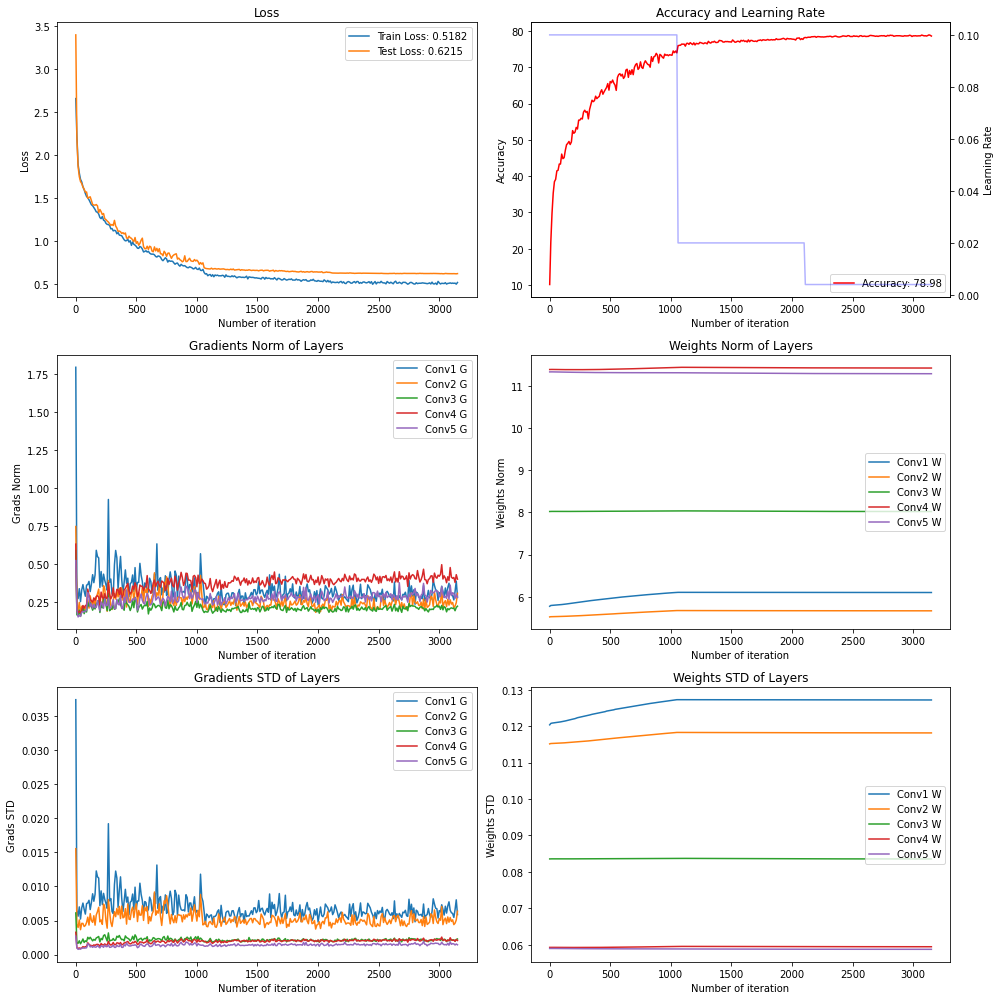

In [37]:
plot_train_test()

Weight 	epoch:0 	conv norm:39.818348 	conv std:0.076504 	conv max:0.609920 	conv  min:-0.612132
Weight 	epoch:1 	conv norm:39.834751 	conv std:0.076535 	conv max:0.611611 	conv  min:-0.614471
Weight 	epoch:21 	conv norm:40.029209 	conv std:0.076909 	conv max:0.660165 	conv  min:-0.673314
Weight 	epoch:42 	conv norm:39.972019 	conv std:0.076799 	conv max:0.690455 	conv  min:-0.684293
Weight 	epoch:63 	conv norm:39.956417 	conv std:0.076769 	conv max:0.692941 	conv  min:-0.683199


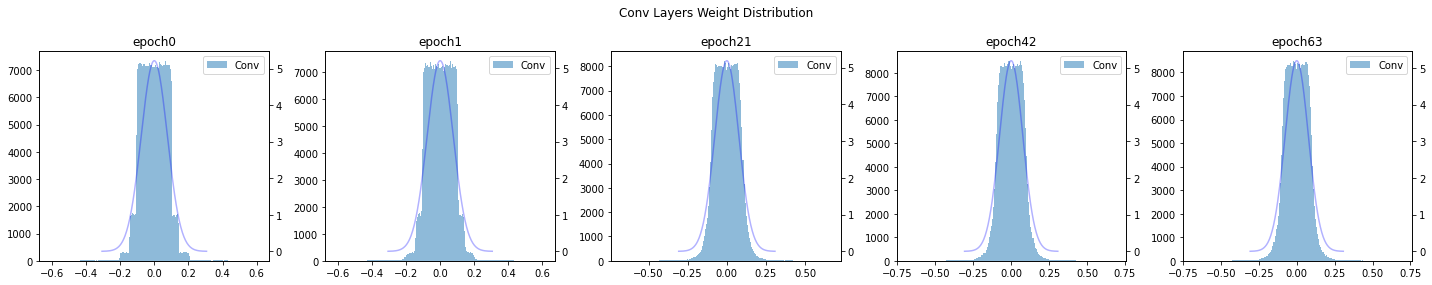

In [38]:
plot_hist(model)

In [12]:
model = resnet20()

#summary(model, (1, 3, 32, 32))

In [13]:
run(model, 'SGD', 'Step', 'uniform')

SGD	Step
----- layer 0 	 layer1.0.conv1.adder 	 param size torch.Size([16, 16, 3, 3]) -----
----- layer 1 	 layer1.0.conv2.adder 	 param size torch.Size([16, 16, 3, 3]) -----
----- layer 2 	 layer1.1.conv1.adder 	 param size torch.Size([16, 16, 3, 3]) -----
----- layer 3 	 layer1.1.conv2.adder 	 param size torch.Size([16, 16, 3, 3]) -----
----- layer 4 	 layer1.2.conv1.adder 	 param size torch.Size([16, 16, 3, 3]) -----
----- layer 5 	 layer1.2.conv2.adder 	 param size torch.Size([16, 16, 3, 3]) -----
----- layer 6 	 layer2.0.conv1.adder 	 param size torch.Size([32, 16, 3, 3]) -----
----- layer 7 	 layer2.0.conv2.adder 	 param size torch.Size([32, 32, 3, 3]) -----
----- layer 8 	 layer2.1.conv1.adder 	 param size torch.Size([32, 32, 3, 3]) -----
----- layer 9 	 layer2.1.conv2.adder 	 param size torch.Size([32, 32, 3, 3]) -----
----- layer 10 	 layer2.2.conv1.adder 	 param size torch.Size([32, 32, 3, 3]) -----
----- layer 11 	 layer2.2.conv2.adder 	 param size torch.Size([32, 32, 3, 3])

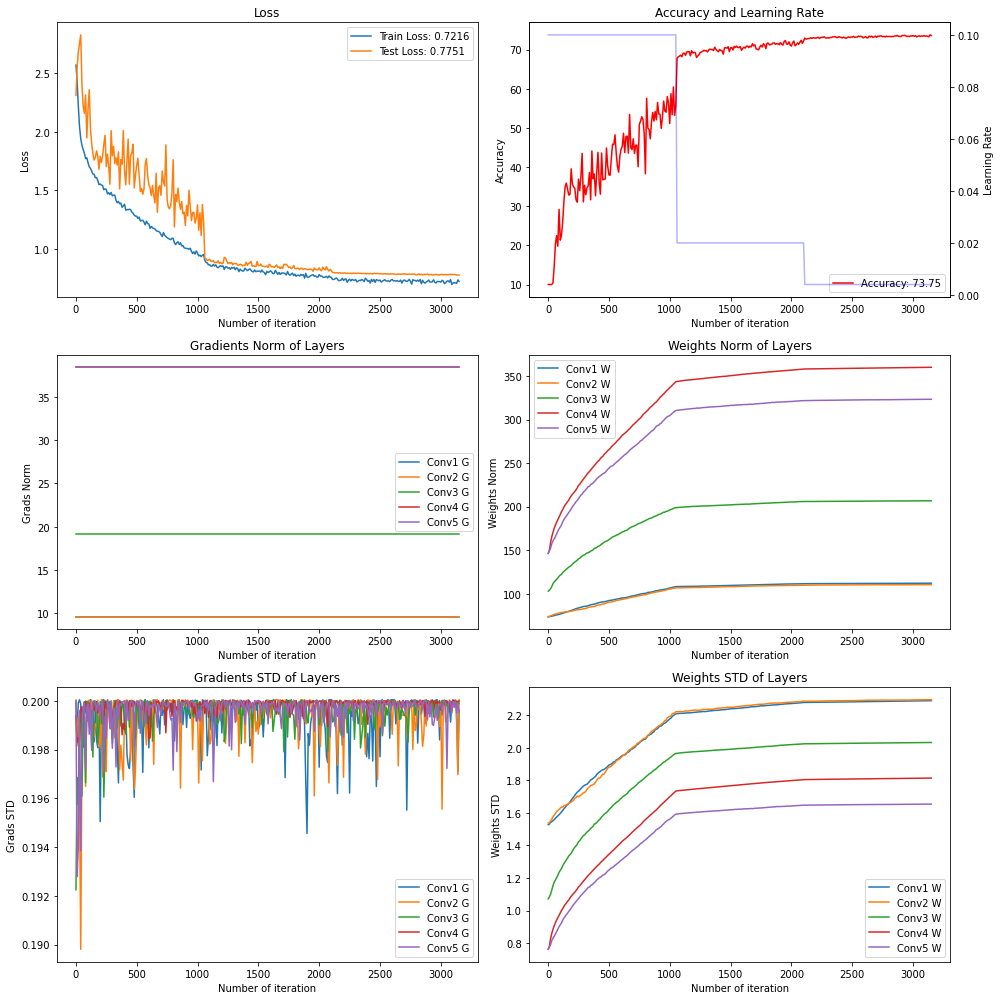

In [14]:
plot_train_test()

Weight 	epoch:0 	adder norm:505.321472	adder std:0.972808	adder max:7.882980	adder min:-7.900225
Weight 	epoch:0 	conv norm:7.201023 	conv std:0.219796 	conv max:0.470684 	conv  min:-0.469436
Weight 	epoch:1 	adder norm:567.872375	adder std:1.087936	adder max:8.938684	adder min:-8.476032
Weight 	epoch:1 	conv norm:7.251069 	conv std:0.221093 	conv max:0.465132 	conv  min:-0.471500
Weight 	epoch:21 	adder norm:982.429382	adder std:1.852228	adder max:26.979971	adder min:-17.748762
Weight 	epoch:21 	conv norm:7.280488 	conv std:0.222237 	conv max:0.550690 	conv  min:-0.541981
Weight 	epoch:42 	adder norm:1017.985962	adder std:1.916544	adder max:26.647900	adder min:-18.846470
Weight 	epoch:42 	conv norm:7.269467 	conv std:0.221899 	conv max:0.556366 	conv  min:-0.545974
Weight 	epoch:63 	adder norm:1023.160217	adder std:1.925789	adder max:26.674355	adder min:-18.859615
Weight 	epoch:63 	conv norm:7.266603 	conv std:0.221808 	conv max:0.559864 	conv  min:-0.547778


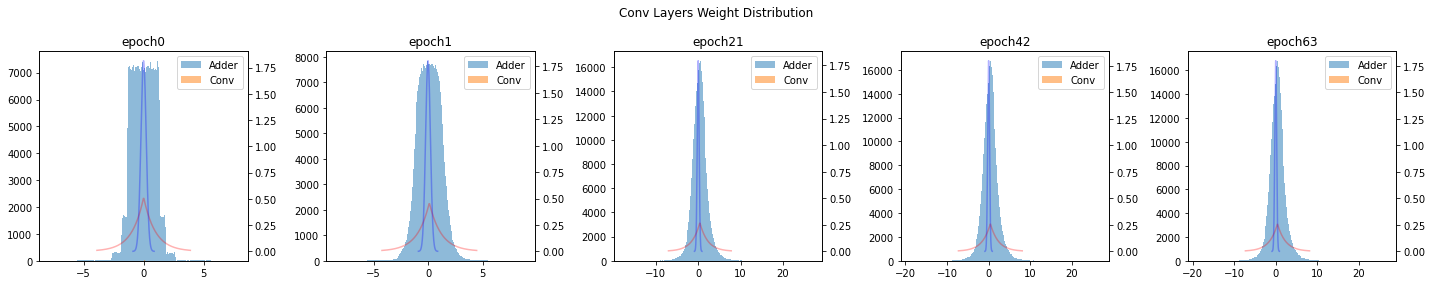

In [15]:
plot_hist(model)

In [16]:
model = resnet20(en_ln=True)

#summary(model, (1, 3, 32, 32))

In [17]:
run(model, 'SGD', 'Step', 'uniform')

SGD	Step
----- layer 0 	 layer1.0.conv1.adder 	 param size torch.Size([16, 16, 3, 3]) -----
----- layer 1 	 layer1.0.conv2.adder 	 param size torch.Size([16, 16, 3, 3]) -----
----- layer 2 	 layer1.1.conv1.adder 	 param size torch.Size([16, 16, 3, 3]) -----
----- layer 3 	 layer1.1.conv2.adder 	 param size torch.Size([16, 16, 3, 3]) -----
----- layer 4 	 layer1.2.conv1.adder 	 param size torch.Size([16, 16, 3, 3]) -----
----- layer 5 	 layer1.2.conv2.adder 	 param size torch.Size([16, 16, 3, 3]) -----
----- layer 6 	 layer2.0.conv1.adder 	 param size torch.Size([32, 16, 3, 3]) -----
----- layer 7 	 layer2.0.conv2.adder 	 param size torch.Size([32, 32, 3, 3]) -----
----- layer 8 	 layer2.1.conv1.adder 	 param size torch.Size([32, 32, 3, 3]) -----
----- layer 9 	 layer2.1.conv2.adder 	 param size torch.Size([32, 32, 3, 3]) -----
----- layer 10 	 layer2.2.conv1.adder 	 param size torch.Size([32, 32, 3, 3]) -----
----- layer 11 	 layer2.2.conv2.adder 	 param size torch.Size([32, 32, 3, 3])

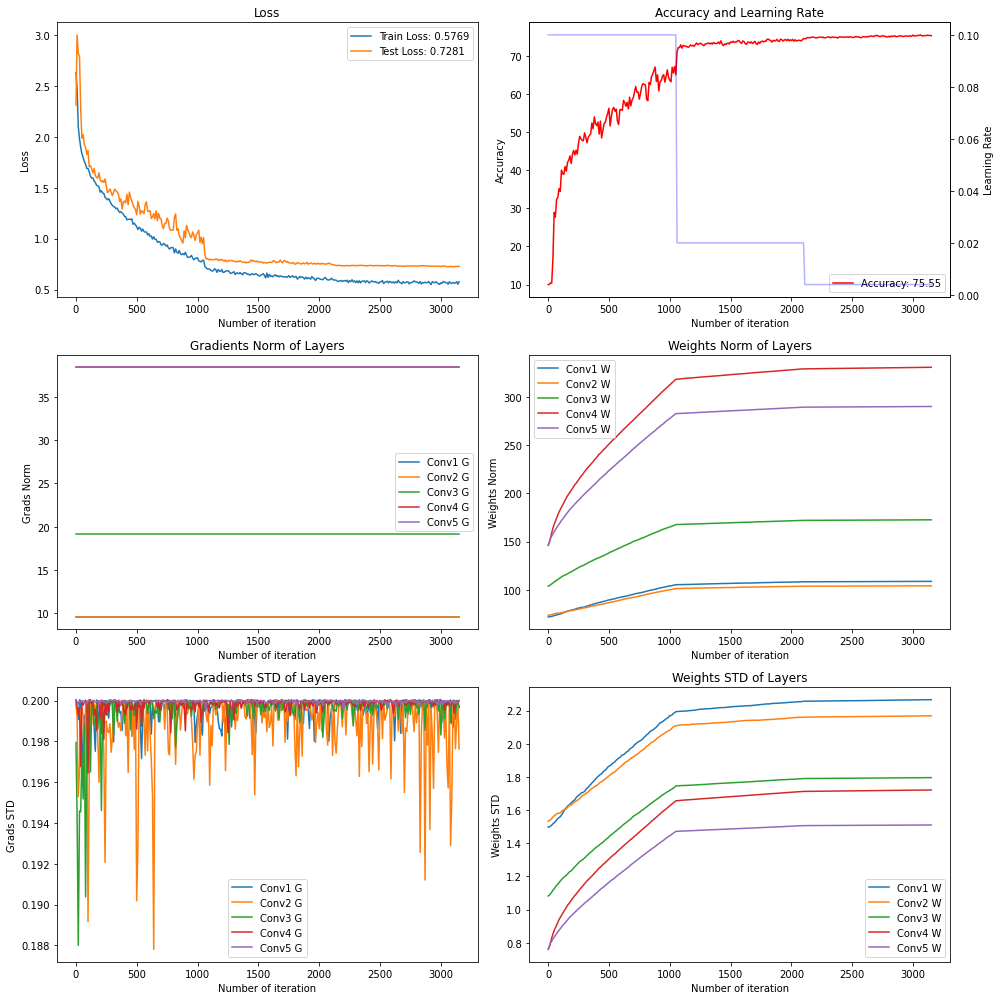

In [18]:
plot_train_test()

Weight 	epoch:0 	adder norm:505.669922	adder std:0.973479	adder max:7.862816	adder min:-7.860203
Weight 	epoch:0 	conv norm:7.137194 	conv std:0.217917 	conv max:0.470500 	conv  min:-0.469736
Weight 	epoch:1 	adder norm:548.355347	adder std:1.055602	adder max:8.499197	adder min:-8.110928
Weight 	epoch:1 	conv norm:7.142858 	conv std:0.218094 	conv max:0.480202 	conv  min:-0.482341
Weight 	epoch:21 	adder norm:900.784058	adder std:1.733986	adder max:16.716938	adder min:-11.521842
Weight 	epoch:21 	conv norm:7.124463 	conv std:0.217551 	conv max:0.523260 	conv  min:-0.506633
Weight 	epoch:42 	adder norm:928.318359	adder std:1.787059	adder max:16.772625	adder min:-12.288033
Weight 	epoch:42 	conv norm:7.112064 	conv std:0.217178 	conv max:0.521937 	conv  min:-0.509108
Weight 	epoch:63 	adder norm:932.170532	adder std:1.794487	adder max:16.973227	adder min:-12.395210
Weight 	epoch:63 	conv norm:7.109191 	conv std:0.217090 	conv max:0.522357 	conv  min:-0.511000


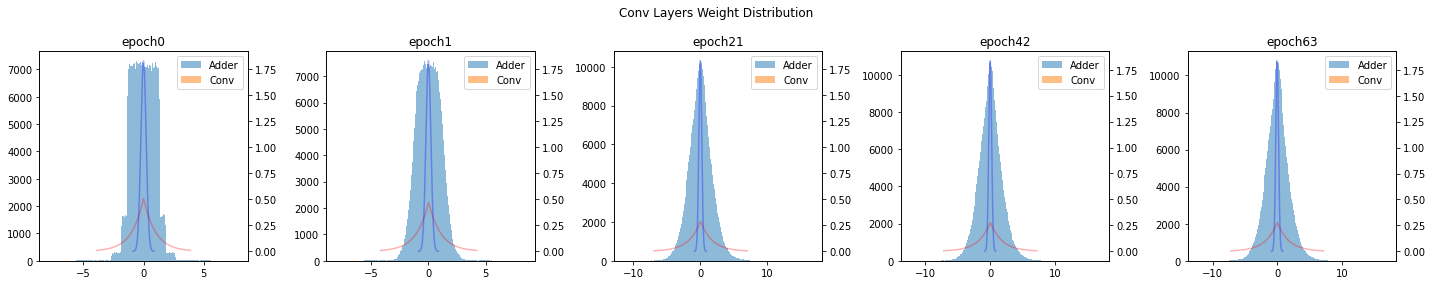

In [19]:
plot_hist(model)

In [39]:
model = resnet20aws()

run(model, 'SGD', 'Step', 'uniform', aws=True)

SGD	Step
normal params conv1.weight
normal params bn1.weight
normal params bn1.bias
normal params layer1.0.conv1.adder
tiny params layer1.0.conv1.scale
tiny params layer1.0.conv1.shift
normal params layer1.0.bn1.weight
normal params layer1.0.bn1.bias
normal params layer1.0.conv2.adder
tiny params layer1.0.conv2.scale
tiny params layer1.0.conv2.shift
normal params layer1.0.bn2.weight
normal params layer1.0.bn2.bias
normal params layer1.1.conv1.adder
tiny params layer1.1.conv1.scale
tiny params layer1.1.conv1.shift
normal params layer1.1.bn1.weight
normal params layer1.1.bn1.bias
normal params layer1.1.conv2.adder
tiny params layer1.1.conv2.scale
tiny params layer1.1.conv2.shift
normal params layer1.1.bn2.weight
normal params layer1.1.bn2.bias
normal params layer1.2.conv1.adder
tiny params layer1.2.conv1.scale
tiny params layer1.2.conv1.shift
normal params layer1.2.bn1.weight
normal params layer1.2.bn1.bias
normal params layer1.2.conv2.adder
tiny params layer1.2.conv2.scale
tiny params l

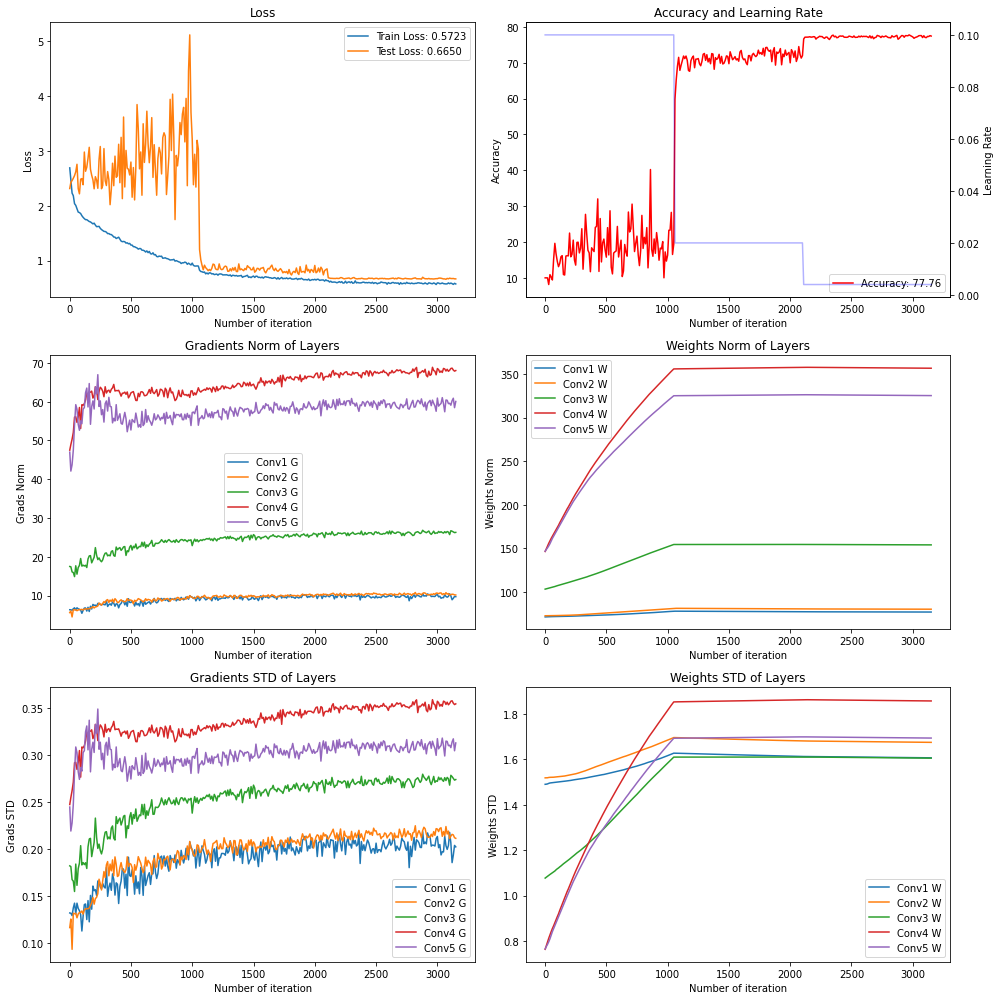

In [40]:
plot_train_test(aws=True)

Weight 	epoch:0 	adder norm:506.250977	adder std:0.974598	adder max:7.895637	adder min:-7.890541
Weight 	epoch:0 	conv norm:7.370908 	conv std:0.224597 	conv max:0.465293 	conv  min:-0.469281
Weight 	epoch:1 	adder norm:528.526489	adder std:1.017481	adder max:8.296613	adder min:-10.475781
Weight 	epoch:1 	conv norm:7.345219 	conv std:0.223293 	conv max:0.467824 	conv  min:-0.490567
Weight 	epoch:21 	adder norm:935.979492	adder std:1.801881	adder max:26.267984	adder min:-27.377077
Weight 	epoch:21 	conv norm:6.745789 	conv std:0.205421 	conv max:0.526865 	conv  min:-0.509477
Weight 	epoch:42 	adder norm:939.301941	adder std:1.808277	adder max:26.240694	adder min:-27.527756
Weight 	epoch:42 	conv norm:6.610637 	conv std:0.201325 	conv max:0.547563 	conv  min:-0.497548
Weight 	epoch:63 	adder norm:936.395752	adder std:1.802682	adder max:25.941910	adder min:-27.787823
Weight 	epoch:63 	conv norm:6.583170 	conv std:0.200493 	conv max:0.544990 	conv  min:-0.494679


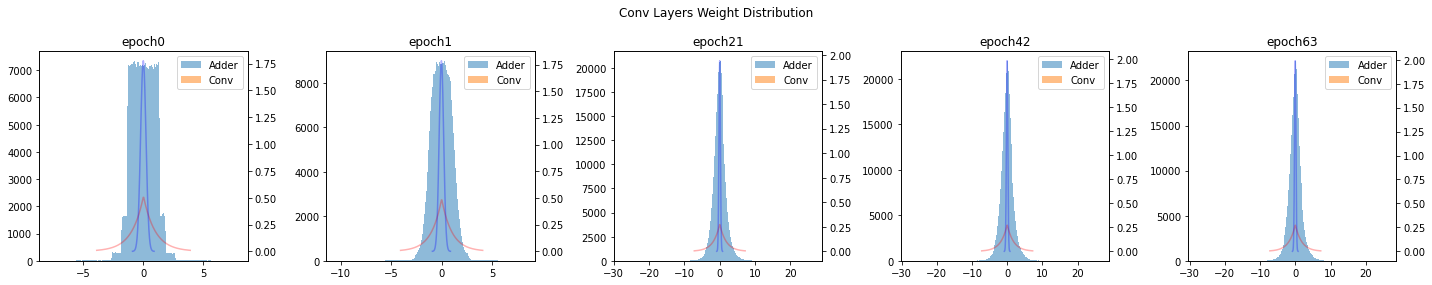

In [41]:
plot_hist(model)

In [42]:
model = resnet20aws(en_ln=True)

run(model, 'SGD', 'Step', 'uniform', aws=True)

SGD	Step
normal params conv1.weight
normal params bn1.weight
normal params bn1.bias
normal params layer1.0.conv1.adder
tiny params layer1.0.conv1.scale
tiny params layer1.0.conv1.shift
normal params layer1.0.bn1.weight
normal params layer1.0.bn1.bias
normal params layer1.0.conv2.adder
tiny params layer1.0.conv2.scale
tiny params layer1.0.conv2.shift
normal params layer1.0.bn2.weight
normal params layer1.0.bn2.bias
normal params layer1.0.ln1.scale
normal params layer1.0.ln1.shift
normal params layer1.0.ln2.scale
normal params layer1.0.ln2.shift
normal params layer1.1.conv1.adder
tiny params layer1.1.conv1.scale
tiny params layer1.1.conv1.shift
normal params layer1.1.bn1.weight
normal params layer1.1.bn1.bias
normal params layer1.1.conv2.adder
tiny params layer1.1.conv2.scale
tiny params layer1.1.conv2.shift
normal params layer1.1.bn2.weight
normal params layer1.1.bn2.bias
normal params layer1.1.ln1.scale
normal params layer1.1.ln1.shift
normal params layer1.1.ln2.scale
normal params lay

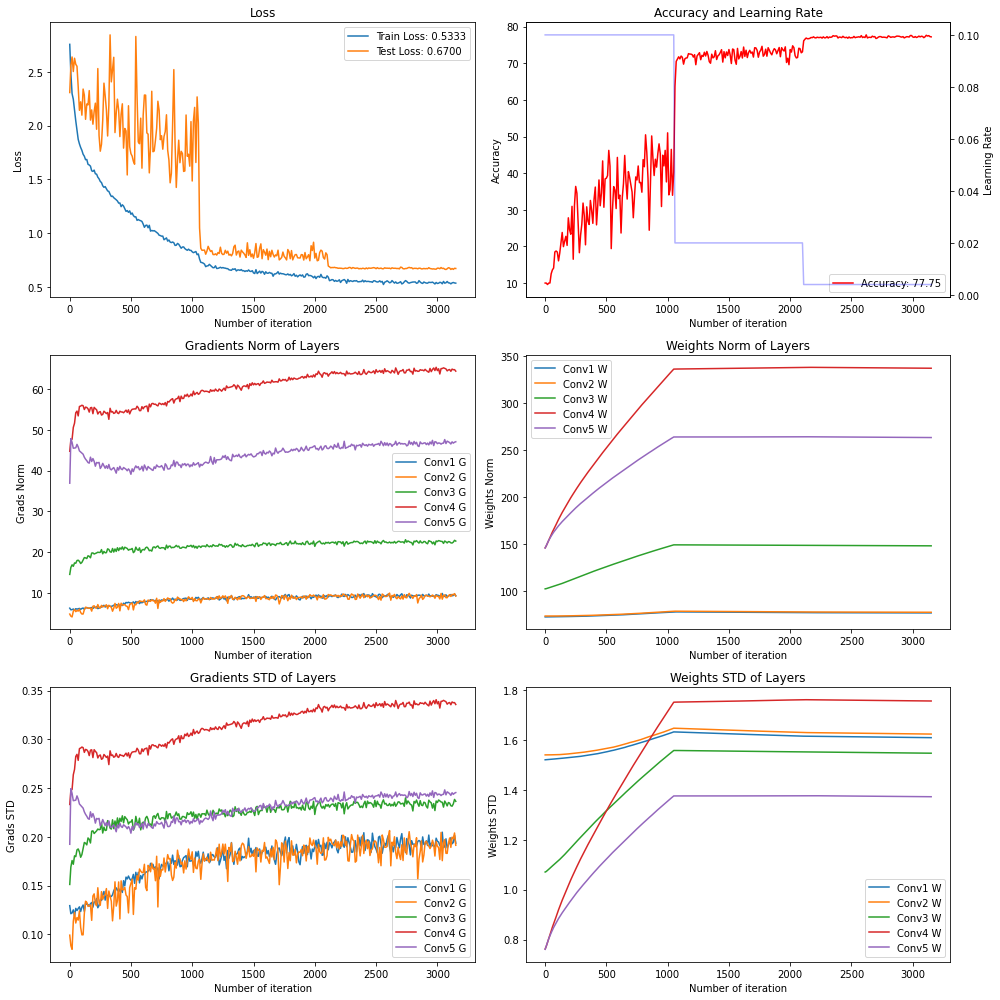

In [43]:
plot_train_test(aws=True)

Weight 	epoch:0 	adder norm:506.770325	adder std:0.975598	adder max:7.894434	adder min:-7.880623
Weight 	epoch:0 	conv norm:7.298583 	conv std:0.222914 	conv max:0.465133 	conv  min:-0.470864
Weight 	epoch:1 	adder norm:529.771729	adder std:1.019879	adder max:8.081331	adder min:-9.846450
Weight 	epoch:1 	conv norm:7.302336 	conv std:0.222848 	conv max:0.503889 	conv  min:-0.504171
Weight 	epoch:21 	adder norm:882.217285	adder std:1.698382	adder max:27.722202	adder min:-25.215097
Weight 	epoch:21 	conv norm:6.665295 	conv std:0.203474 	conv max:0.472668 	conv  min:-0.481075
Weight 	epoch:42 	adder norm:884.123840	adder std:1.702052	adder max:27.812696	adder min:-23.475283
Weight 	epoch:42 	conv norm:6.529801 	conv std:0.199355 	conv max:0.463717 	conv  min:-0.468062
Weight 	epoch:63 	adder norm:881.347900	adder std:1.696708	adder max:29.188972	adder min:-23.882902
Weight 	epoch:63 	conv norm:6.502575 	conv std:0.198527 	conv max:0.463113 	conv  min:-0.467425


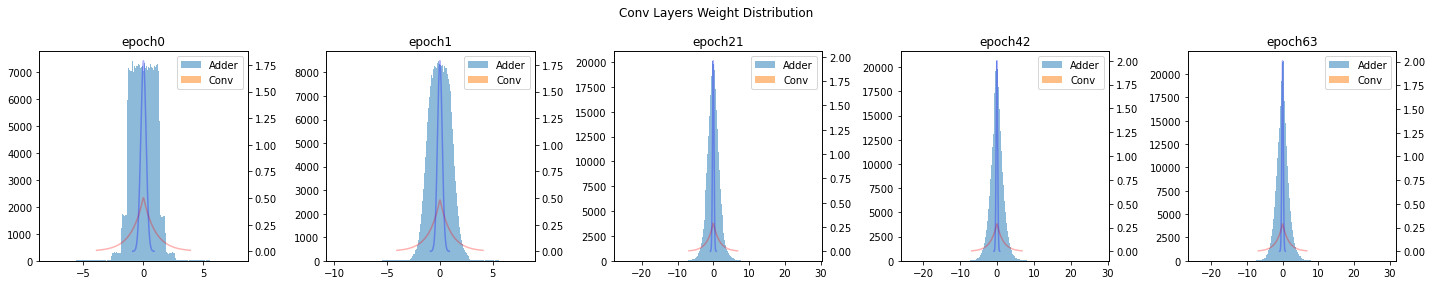

In [44]:
plot_hist(model)